In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv

--2025-11-05 17:43:22--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 874188 (854K) [text/plain]
Saving to: ‘car_fuel_efficiency.csv’

car_fuel_efficiency 100%[===================>] 853.70K  --.-KB/s    in 0.02s   

2025-11-05 17:43:22 (41.4 MB/s) - ‘car_fuel_efficiency.csv’ saved [874188/874188]



In [135]:
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import export_text
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

## Data Acuisition

In [9]:
raw_df = pd.read_csv('car_fuel_efficiency.csv')

In [10]:
df = raw_df.fillna(0)

## Train-val-test split

In [34]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [35]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [36]:
y_train = df_train['fuel_efficiency_mpg']
y_val = df_val['fuel_efficiency_mpg']
y_test = df_test['fuel_efficiency_mpg']

In [37]:
df_train.drop('fuel_efficiency_mpg', axis=1, inplace=True)
df_val.drop('fuel_efficiency_mpg', axis=1, inplace=True)
df_test.drop('fuel_efficiency_mpg', axis=1, inplace=True)

## Data Preparation

In [38]:
train_dicts = df_train.fillna(0).to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

## Question 1

In [39]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [40]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- vehicle_weight <= 3022.11
|   |--- value: [16.88]
|--- vehicle_weight >  3022.11
|   |--- value: [12.94]



In [41]:
print('Answer to Q1 is: vehicle_weight')

Answer to Q1 is: vehicle_weight


## Question 2

In [55]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

,n_estimators,10
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [56]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [58]:
y_pred = rf.predict(X_val)
rf_error = root_mean_squared_error(y_val, y_pred)

In [59]:
print(f"Answer to Q2 is: {rf_error}")

Answer to Q2 is: 0.4599777557336149


## Question 3

In [95]:
errors = {}
for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rf_error = root_mean_squared_error(y_val, y_pred)
    errors[n] = rf_error

In [115]:
errors_df = pd.DataFrame(errors.items(), columns=['n_estimators', 'rmse'])
errors_df['rmse_drop'] = round(errors_df['rmse'] - errors_df['rmse'].shift(1), 3)

In [118]:
errors_df

,n_estimators,rmse,rmse_drop
0,10,0.459978,NaN
1,20,0.453659,-0.006
2,30,0.450743,-0.003
3,40,0.448007,-0.003
4,50,0.446151,-0.002
5,60,0.445266,-0.001
6,70,0.444610,-0.001
7,80,0.444893,0.000
8,90,0.444724,-0.000
9,100,0.444318,-0.000


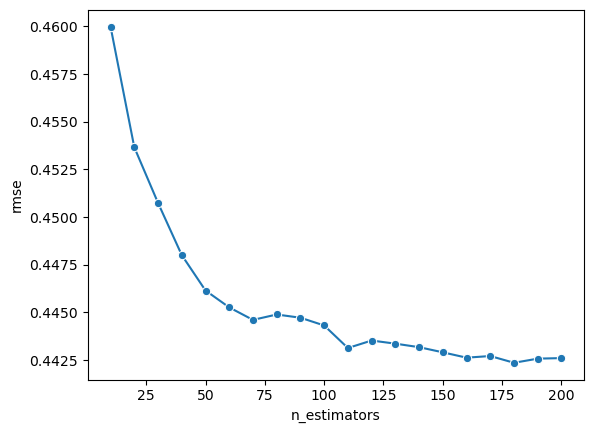

In [116]:
sns.lineplot(data=errors_df, x='n_estimators', y='rmse', marker='o')

plt.xlabel('n_estimators')
plt.ylabel('rmse')

plt.show()

In [123]:
print("Answer to Q3 is: 80. \nThe RMSE difference between the steps starts to show zeros (if rounded to 3 digits) right after n_estimators = 80.")

Answer to Q3 is: 80. 
The RMSE difference between the steps starts to show zeros (if rounded to 3 digits) right after n_estimators = 80.


## Question 4

In [122]:
errors = {}
for md in [10, 15, 20, 25]:
    errors_by_n = []
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=md, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rf_error = root_mean_squared_error(y_val, y_pred)
        errors_by_n.append(rf_error)
    errors[md] = float(np.mean(errors_by_n))

In [94]:
print(f"Answer to Q4 is: {min(errors, key=errors.get)}")

Answer to Q4 is: 10


## Question 5

In [127]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
rf.feature_importances_

array([1.14707165e-02, 3.81809750e-04, 3.11842085e-04, 3.26932342e-03,
       3.43693411e-04, 3.36671988e-04, 1.60402148e-02, 3.18229841e-03,
       2.35867094e-03, 1.59113306e-03, 4.76103046e-04, 5.20358083e-04,
       5.55151959e-04, 9.59162013e-01])

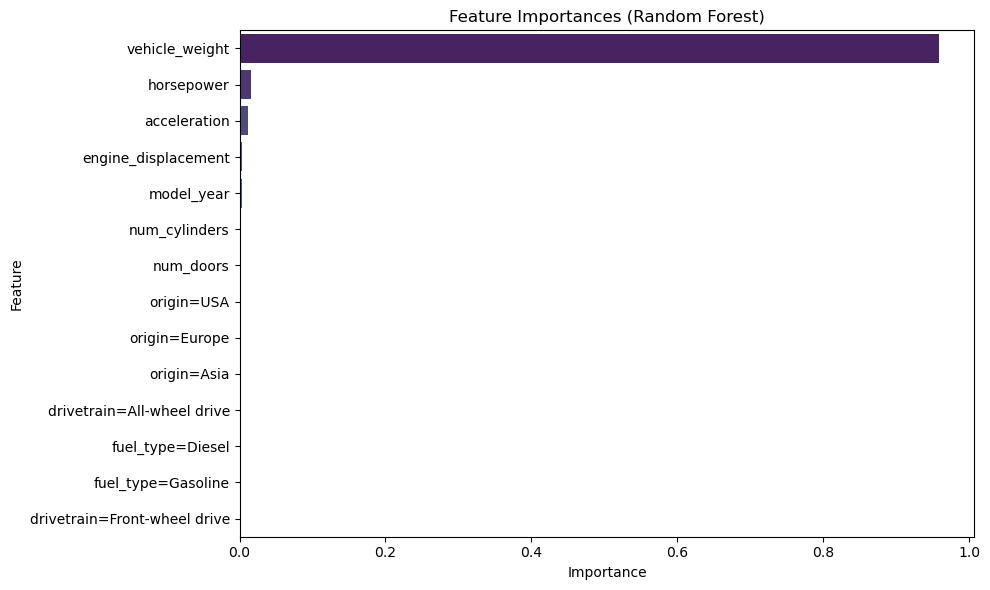

In [133]:
# Get feature names from DictVectorizer
feature_names = dv.get_feature_names_out()

# Create DataFrame for feature importances
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    hue='Feature',
    data=feat_imp,
    palette='viridis',
    dodge=False,
    legend=False
)
plt.title('Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [134]:
print("Answer to Question 5 is: vehicle_weight")

Answer to Question 5 is: vehicle_weight


## Question 6

In [154]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [155]:
evals_result = {}

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    'eval_metric': 'rmse',
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

watchlist = [(dtrain, 'train'), (dval, 'val')]

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals_result=evals_result,
                  evals=watchlist)

[0]	train-rmse:1.81393	val-rmse:1.85444
[5]	train-rmse:0.51381	val-rmse:0.55664
[10]	train-rmse:0.37115	val-rmse:0.43896
[15]	train-rmse:0.34666	val-rmse:0.43362
[20]	train-rmse:0.33553	val-rmse:0.43376
[25]	train-rmse:0.32268	val-rmse:0.43683
[30]	train-rmse:0.31475	val-rmse:0.43752
[35]	train-rmse:0.30960	val-rmse:0.43784
[40]	train-rmse:0.30202	val-rmse:0.43968
[45]	train-rmse:0.29126	val-rmse:0.44024
[50]	train-rmse:0.28456	val-rmse:0.44140
[55]	train-rmse:0.27618	val-rmse:0.44225
[60]	train-rmse:0.26768	val-rmse:0.44290
[65]	train-rmse:0.26174	val-rmse:0.44352
[70]	train-rmse:0.25489	val-rmse:0.44531
[75]	train-rmse:0.24792	val-rmse:0.44628
[80]	train-rmse:0.24254	val-rmse:0.44689
[85]	train-rmse:0.23644	val-rmse:0.44749
[90]	train-rmse:0.23193	val-rmse:0.44839
[95]	train-rmse:0.22475	val-rmse:0.44904
[99]	train-rmse:0.21950	val-rmse:0.45018


In [156]:
print(f"eta=0.3: {np.mean(evals_result['val']['rmse'])}")

eta=0.3: 0.47863791683696044


In [157]:
evals_result = {}

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    'eval_metric': 'rmse',
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

watchlist = [(dtrain, 'train'), (dval, 'val')]

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals_result=evals_result,
                  evals=watchlist)

[0]	train-rmse:2.28944	val-rmse:2.34561
[5]	train-rmse:1.41247	val-rmse:1.44988
[10]	train-rmse:0.91008	val-rmse:0.94062
[15]	train-rmse:0.63402	val-rmse:0.66672
[20]	train-rmse:0.48983	val-rmse:0.53064
[25]	train-rmse:0.41881	val-rmse:0.46891
[30]	train-rmse:0.38342	val-rmse:0.44289
[35]	train-rmse:0.36435	val-rmse:0.43250
[40]	train-rmse:0.35343	val-rmse:0.42746
[45]	train-rmse:0.34621	val-rmse:0.42595
[50]	train-rmse:0.33998	val-rmse:0.42498
[55]	train-rmse:0.33480	val-rmse:0.42449
[60]	train-rmse:0.33054	val-rmse:0.42456
[65]	train-rmse:0.32602	val-rmse:0.42493
[70]	train-rmse:0.32202	val-rmse:0.42503
[75]	train-rmse:0.31895	val-rmse:0.42526
[80]	train-rmse:0.31667	val-rmse:0.42563
[85]	train-rmse:0.31440	val-rmse:0.42574
[90]	train-rmse:0.31059	val-rmse:0.42586
[95]	train-rmse:0.30625	val-rmse:0.42611
[99]	train-rmse:0.30419	val-rmse:0.42623


In [158]:
print(f"eta=0.1: {np.mean(evals_result['val']['rmse'])}")

eta=0.1: 0.5761123955454157


In [160]:
print("Answer to Q6 is: 0.3")

Answer to Q6 is: 0.3
